# Annotations of blink and muscle artifacts

## Introduction

We will show here how artifacts can be identified and then annocated. The annotations will be represented in the FIF data file. Sections or trials will not be rejected at this stage; rather the annotations may be used later. For instance, they can be used to reject trials with eyeblinks or muscle contractions depending on their relevance for the analysis.  



## Preparation

Import the relevant modules: 

In [1]:
import os.path as op
import os
import sys
import numpy as np
from mne.preprocessing import annotate_muscle_zscore
import mne

Set the path and load the FIF-files: 

In [2]:
# data_path = r'C:\Users\JensenO\Dropbox\FLUX\Development\FLUX\data'
# data_path = r'C:\Users\Ole\Dropbox\FLUX\Development\FLUX\data'
data_path = r'D:\FLUX\results'
file_name = ['training_rawsss-1.fif','training_rawsss-2.fif']
path_data = os.path.join(data_path,file_name[0]) 
result_path = data_path

data1 = mne.io.read_raw_fif(path_data,preload=True)

Opening raw data file C:\Users\ferranto\Downloads\flux_sample\results\training_rawsss-1.fif...


<ipython-input-2-f4d276492597>:8: RuntimeWarning: This filename (C:\Users\ferranto\Downloads\flux_sample\results\training_rawsss-1.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  data1 = mne.io.read_raw_fif(path_data,preload=True)


    Range : 208000 ... 1664999 =    208.000 ...  1664.999 secs
Ready.
Reading 0 ... 1456999  =      0.000 ...  1456.999 secs...


## Identifying eye blinks

Here we show how the artifacts associated with eye blinks can be marked automatically on the basis of the vertical EOG channel (EOG001 in our case). After bandpass filtering the EOG signal between 1 - 10 Hz, the threshold for blink detection is determined according to:

$$ (max(hEOG) - min(hEOG)) / 4 $$

 Segments being 500 ms long starting 250 ms prior to exceeding the threshold are annocated as blinks. 

In [3]:
eog_events = mne.preprocessing.find_eog_events(data1, ch_name='EOG001') 

Using EOG channel: EOG001
EOG channel index for this subject is: [0]
Filtering the data to remove DC offset to help distinguish blinks from saccades
Setting up band-pass filter from 1 - 10 Hz

FIR filter parameters
---------------------
Designing a two-pass forward and reverse, zero-phase, non-causal bandpass filter:
- Windowed frequency-domain design (firwin2) method
- Hann window
- Lower passband edge: 1.00
- Lower transition bandwidth: 0.50 Hz (-12 dB cutoff frequency: 0.75 Hz)
- Upper passband edge: 10.00 Hz
- Upper transition bandwidth: 0.50 Hz (-12 dB cutoff frequency: 10.25 Hz)
- Filter length: 10000 samples (10.000 sec)

Now detecting blinks and generating corresponding events
Found 543 significant peaks
Number of EOG events detected: 543


In total, 543 events were indentified as blinks. In order to write these events on the dataset, we need to create an Annotation object with contains the onset of each blink, their durations and a description (i.e., tag) of the type of event:

In [4]:
n_blinks = len(eog_events)  
onset = eog_events[:, 0] / data1.info['sfreq'] - 0.25  
onset -= data1._first_time  
duration = np.repeat(0.5, n_blinks)  
description = ['blink'] * n_blinks  
annotations_blink = mne.Annotations(onset,duration,description)

## Finding muscle artifacts

Muscle artefact are identified from the magnetometer data filtered in the 110 - 140 Hz range. The data are subsequently z-scored. If they exceed the value *threshold_muscle*, the corresponding section of data is annotated as muscle artifact. The shortest allowed duration of non-annotated data is 0.2 s; shorter segments will be incorporated into the surrounding annotations.

In [5]:
# We start by applying a notch filter
data1filt = data1.copy().notch_filter([50, 100])

# Then we perform the muscle artifact annotation
threshold_muscle = 10  
annotations_muscle, scores_muscle = annotate_muscle_zscore(
    data1, ch_type="mag", threshold=threshold_muscle, min_length_good=0.2,
    filter_freq=[110, 140])

Setting up band-stop filter

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower transition bandwidth: 0.50 Hz
- Upper transition bandwidth: 0.50 Hz
- Filter length: 6601 samples (6.601 sec)

Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1.1e+02 - 1.4e+02 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 110.00
- Lower transition bandwidth: 27.50 Hz (-6 dB cutoff frequency: 96.25 Hz)
- Upper passband edge: 140.00 Hz
- Upper transition bandwidth: 35.00 Hz (-6 dB cutoff frequency: 157.50 Hz)
- Filter length: 121 samples (0.121 sec)

Setting up low-pass filter at 4 Hz

FIR filt

## Include annotations in dataset and inspect

Now mark all the annotations in the data set: 

In [6]:
data1.set_annotations(annotations_blink+annotations_muscle);

<ipython-input-6-12dc339c5b7a>:1: RuntimeWarning: Limited 1 annotation(s) that were expanding outside the data range.
  data1.set_annotations(annotations_blink+annotations_muscle);


In [7]:
annotations_blink.onset

array([-2.500000e-01,  1.490000e-01,  1.798000e+00,  4.000000e+00,
        6.835000e+00,  7.501000e+00,  1.041900e+01,  1.131300e+01,
        1.339100e+01,  1.403100e+01,  1.652400e+01,  1.748700e+01,
        1.809100e+01,  1.848200e+01,  1.878700e+01,  1.905400e+01,
        1.971800e+01,  2.158000e+01,  2.870400e+01,  2.912900e+01,
        2.968900e+01,  2.995300e+01,  3.027000e+01,  3.641800e+01,
        3.679800e+01,  3.717700e+01,  3.752400e+01,  3.813800e+01,
        4.361000e+01,  4.394200e+01,  4.431500e+01,  5.253000e+01,
        5.290700e+01,  5.337900e+01,  6.043700e+01,  6.080700e+01,
        6.109700e+01,  6.836800e+01,  6.885000e+01,  6.943000e+01,
        7.736200e+01,  7.792300e+01,  7.845900e+01,  8.681900e+01,
        8.717600e+01,  9.336300e+01,  9.384000e+01,  1.001840e+02,
        1.006400e+02,  1.011620e+02,  1.081070e+02,  1.086890e+02,
        1.091170e+02,  1.097420e+02,  1.173180e+02,  1.269790e+02,
        1.274980e+02,  1.346160e+02,  1.349770e+02,  1.430200e

To inspect the annotations write

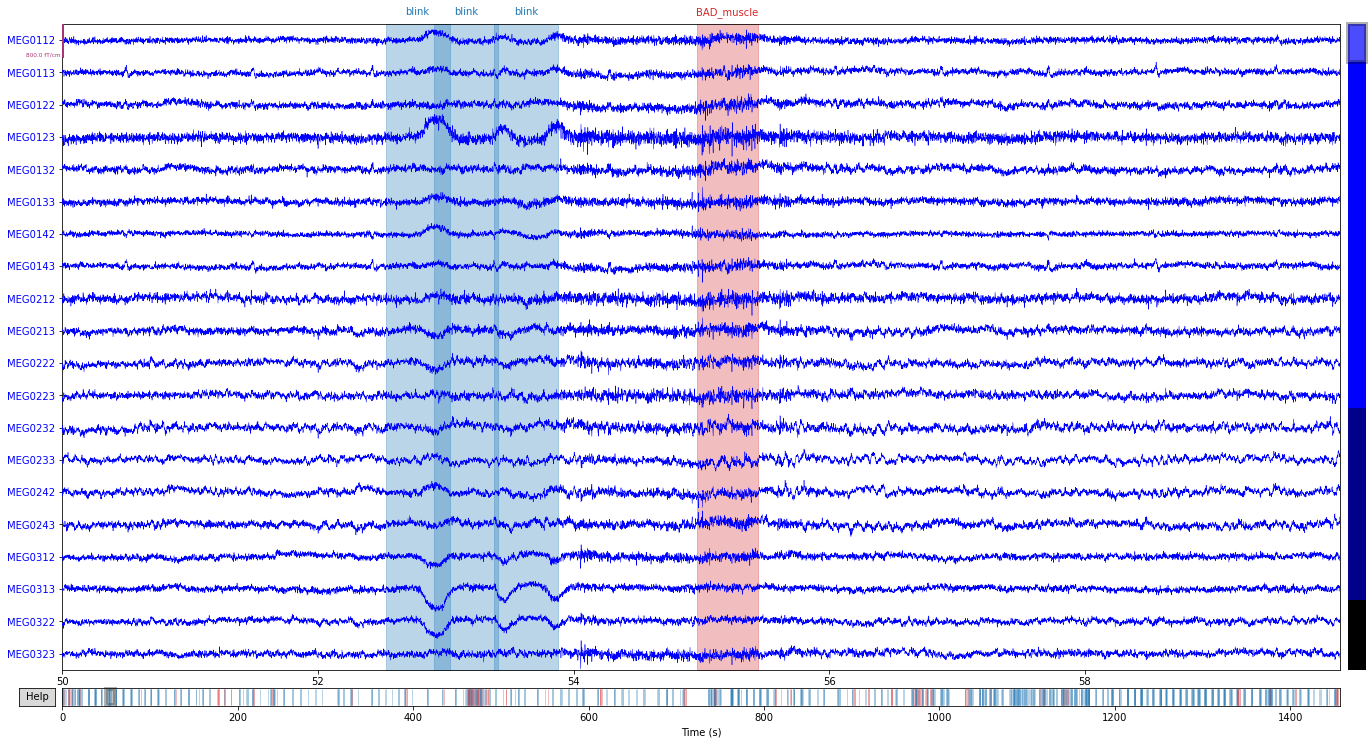

In [8]:
%matplotlib inline
data1.plot(start=50);

To specifically inspect the ocular artifacts display the EOG sensors: 

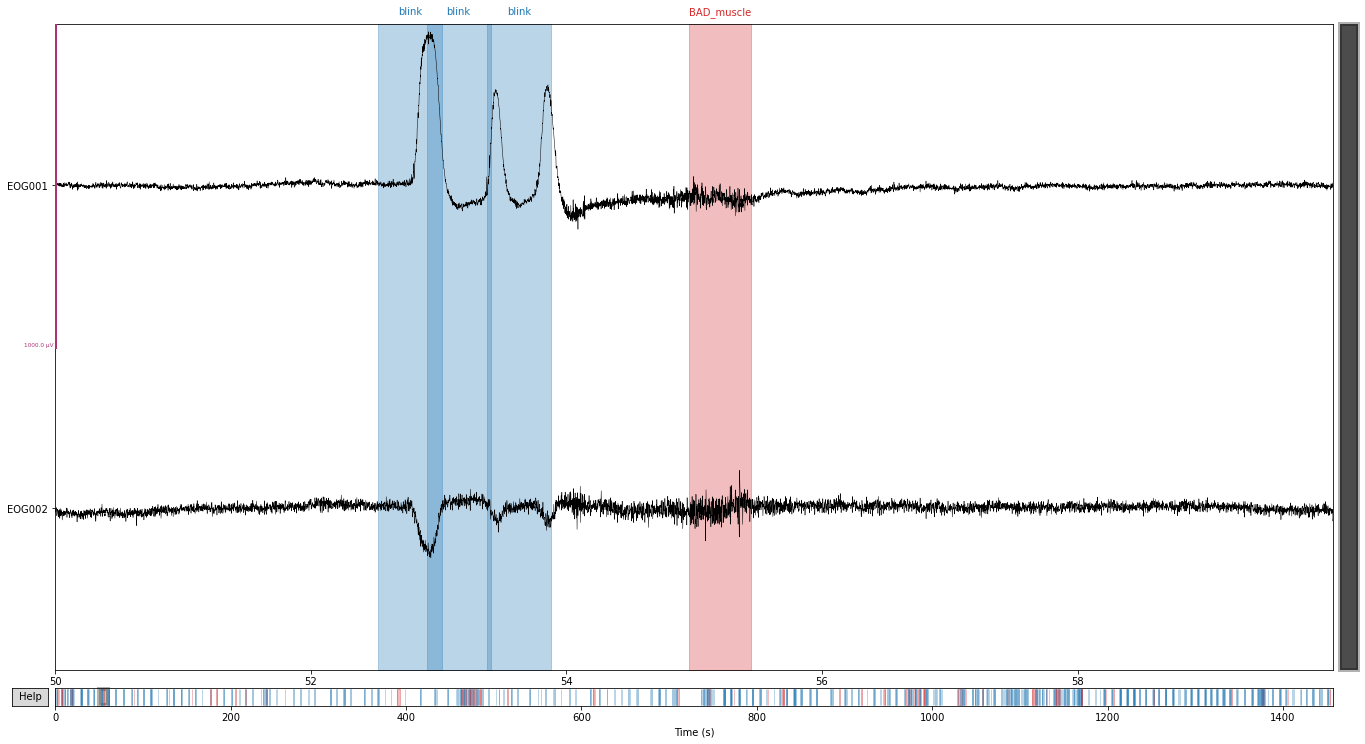

In [9]:
# Set the channel type as 'eog'
data1.set_channel_types({'EOG001': 'eog'})
data1.set_channel_types({'EOG002': 'eog'})

eog_picks = mne.pick_types(data1.info, meg=False, eog=True)

scl = dict(eog=500e-6)
data1.plot(order=eog_picks, scalings=scl, start=50);

## Save the artifact annotations

Save the data to a FIF-file to be used in the subsequent sections:

In [10]:
path_file_results = os.path.join(result_path,'training_rawann-1.fif') 
path_file_results
data1.save(path_file_results,overwrite=True) 

Overwriting existing file.
Writing C:\Users\ferranto\Downloads\flux_sample\results\training_rawann-1.fif


<ipython-input-10-731db7207489>:3: RuntimeWarning: This filename (C:\Users\ferranto\Downloads\flux_sample\results\training_rawann-1.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  data1.save(path_file_results,overwrite=True)


Closing C:\Users\ferranto\Downloads\flux_sample\results\training_rawann-1.fif
[done]


## Perform the annocations on the rest of the dataset 

Now perform the annotation operations on the second FIF-file:

In [11]:
path_data = os.path.join(data_path,file_name[1]) 
data2 = mne.io.read_raw_fif(path_data,preload=True)

# Blinks
eog_events = mne.preprocessing.find_eog_events(data2,ch_name = 'EOG001') 
n_blinks = len(eog_events)  
onset = eog_events[:, 0] / data1.info['sfreq'] - 0.25
onset -= data1._first_time  
duration = np.repeat(0.5, n_blinks)  
description = ['blink'] * n_blinks  
annotations_blink = mne.Annotations(onset,duration,description)

annotations_sacc = mne.Annotations(onset,duration,description)

# Muscle
data2filt = data2.copy().notch_filter([50, 100])
threshold_muscle = 5  
annotations_muscle, scores_muscle = annotate_muscle_zscore(
    data2, ch_type="mag", threshold=threshold_muscle, min_length_good=0.2,
    filter_freq=[110, 140])

# Annotate
data2.set_annotations(annotations_blink+annotations_muscle)  

# Save FIF
path_file_results = os.path.join(result_path,'training_rawann-2.fif') 
path_file_results
data2.save(path_file_results,overwrite=True) 


Opening raw data file C:\Users\ferranto\Downloads\flux_sample\results\training_rawsss-2.fif...


<ipython-input-11-aed3ce59eb3c>:2: RuntimeWarning: This filename (C:\Users\ferranto\Downloads\flux_sample\results\training_rawsss-2.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  data2 = mne.io.read_raw_fif(path_data,preload=True)


    Range : 1665000 ... 3098999 =   1665.000 ...  3098.999 secs
Ready.
Reading 0 ... 1433999  =      0.000 ...  1433.999 secs...
Using EOG channel: EOG001
EOG channel index for this subject is: [0]
Filtering the data to remove DC offset to help distinguish blinks from saccades
Setting up band-pass filter from 1 - 10 Hz

FIR filter parameters
---------------------
Designing a two-pass forward and reverse, zero-phase, non-causal bandpass filter:
- Windowed frequency-domain design (firwin2) method
- Hann window
- Lower passband edge: 1.00
- Lower transition bandwidth: 0.50 Hz (-12 dB cutoff frequency: 0.75 Hz)
- Upper passband edge: 10.00 Hz
- Upper transition bandwidth: 0.50 Hz (-12 dB cutoff frequency: 10.25 Hz)
- Filter length: 10000 samples (10.000 sec)

Now detecting blinks and generating corresponding events
Found 487 significant peaks
Number of EOG events detected: 487
Setting up band-stop filter

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-cau

<ipython-input-11-aed3ce59eb3c>:23: RuntimeWarning: Omitted 487 annotation(s) that were outside data range.
  data2.set_annotations(annotations_blink+annotations_muscle)
<ipython-input-11-aed3ce59eb3c>:28: RuntimeWarning: This filename (C:\Users\ferranto\Downloads\flux_sample\results\training_rawann-2.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  data2.save(path_file_results,overwrite=True)


Closing C:\Users\ferranto\Downloads\flux_sample\results\training_rawann-2.fif
[done]


## Pregistration and publication

Preregistration: report the the type of artifacts being annotated and well ass the threshold selections. 


Publication, example:

"Artefacts were annotated in the raw data such that they later could be used to reject trials if relevant. Ocular artefacts were identified in the vertical EOG data (bandpass filtered at 1 - 10 Hz) according to segments exceeding a threshold defined according to (max(EOG) - min(EOG))/4. Ocular artefacts were consired 500 ms long centered around the time they exceeded the threshold. Muscle artefacts were identified in magnetometers data bandpass filtered at 110 - 140 Hz. The filtered data were z-scored and segments exceeding a z-score of 10 were annotated as muscle artefacts. " 

## References 

Suresh Muthukumaraswamy. High-frequency brain activity and muscle artifacts in MEG/EEG: a review and recommendations. Frontiers in Human Neuroscience, 7:138, 2013.
